# Counter Current Heat Exchanger

In [236]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import style
import scipy, scipy.integrate, scipy.optimize, scipy.interpolate
from IPython.display import display, Math
from PIL import Image

%config InlineBackend.figure_format = 'retina'

style.use("seaborn-dark")

%matplotlib inline

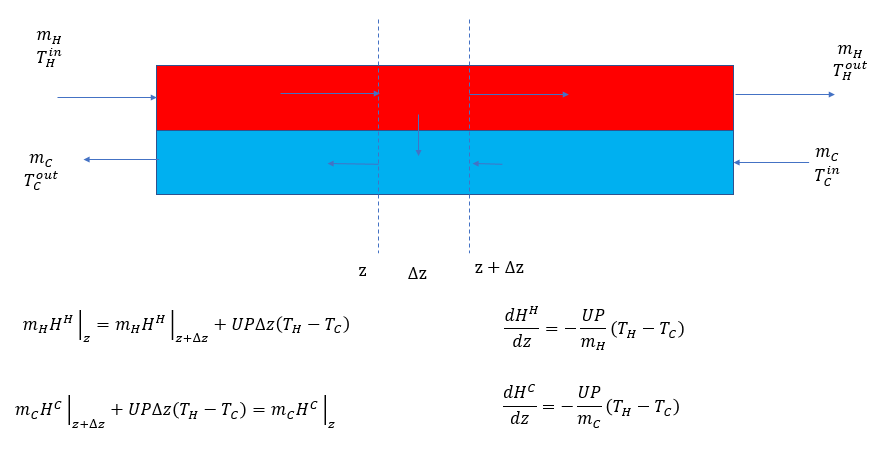

In [237]:
Image.open('Capture_cross_current_heatx.png')

## Compunds used here are Benzene(hot) and Water(cold)

### Cp is of the form : $ \frac{C_{p}}{R} = A+BT+CT^{2}  $ <br> *(T can go from 273.16 K to 373.16 K)*

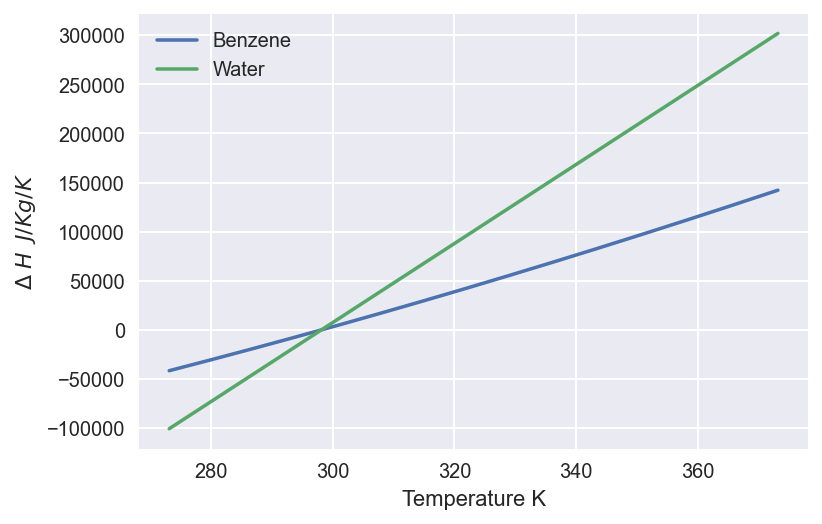

In [238]:
R = 8.314462  # J/K/gmol
global ref_T 
ref_T = 298.16 # K

def Cp_benz(T):
    #Cn = [15.819, 29.03e-3, -15.8e-6] # Analine, 93.13
    Cn = [-0.747, 67.96, -37.78] #Benzene, 78
    #Cn = [13.431, -51.28, 131.13] # Methanol, 32.04
    #Cn = [-9.048, 141.38, -161.62] # Cyclohexanol, 100.158
    #Cn = [15.133, 6.79, 16.35] # Toluene, 92.14
   
    H =  R*(Cn[0]*(T - ref_T) + (Cn[1]*1e-3)*(T**2 - ref_T**2)/2 + (Cn[2]*1e-6)*(T**3 - ref_T**3)/3)*(1000/78)
    
    return H
    
def Cp_water(T):
    Cn = [8.712, 1.25e-3, -0.18e-6]
    
    H =  R*(Cn[0]*(T - ref_T) + (Cn[1]*1e-3)*(T**2 - ref_T**2)/2 + (Cn[2]*1e-6)*(T**3 - ref_T**3)/3)*(1000/18)
    
    return H

T = np.linspace(273.16, 373.16, 1000)
plt.plot(T, Cp_benz(T), label = 'Benzene')
plt.plot(T, Cp_water(T), label = 'Water')
plt.xlabel('Temperature K')
plt.ylabel('$\Delta \; H \; \; J/Kg/K $')
plt.legend()
plt.grid(True)

## Definig a class containing all Information about Heat Exchanger

In [239]:
class CrossHeatx():
    def __init__(self):
        #Boundary Conditions :
        self.T_Cin = 290.16 #K
        self.T_Hin = 353.16 #K
        # Other Physical Quantities :
        self.U = 800.0 #W/m2-K, Overall heat transfer coefficient
        self.P = 0.1 #m2/m, specific area available for heat transfer
        self.L = 1 #m, Length of heat exchanger
        self.mH = 1 #kg/s, mass flowrate of Hot Fluid
        self.mC = 8 #kg/s, mass flowrate of Cold Fluid
        #self.Tc_out = 300  #K, outlet Temperature of cold fluid
    
    def interpolate(self):
        T = np.linspace(self.T_Cin, self.T_Hin, 1000)
        self.T_H = scipy.interpolate.UnivariateSpline(Cp_benz(T), T, k=1, s=0)
        self.T_C = scipy.interpolate.UnivariateSpline(Cp_water(T), T, k=1, s=0)  
    
        
    
    def solve(self, n = 100):        
        self.interpolate()        
        guess = [self.T_Cin + 0.0]
        
        lsq = scipy.optimize.least_squares(shoot_error, guess, args = (self,) )
        
        SV0 = [Cp_benz(self.T_Hin), Cp_water(self.TC_out)]
        z = np.linspace(0,self.L, n)
        solution = scipy.integrate.odeint( odefunc,
                                           SV0,
                                           z ,
                                            args = (self,))
        H_Hsol = solution[:,0]
        H_Csol = solution[:,1]
        self.delT_in = self.T_H(H_Hsol[0]) - self.T_C(H_Csol[0])
        self.delT_out = self.T_H(H_Hsol[-1]) - self.T_C(H_Csol[-1])
        self.lmtd = (self.delT_in-self.delT_out)/np.log(self.delT_in/self.delT_out)
        
        self.solutiondf = pd.DataFrame({
                                    "z":z,
                                    "T_H":self.T_H(H_Hsol),
                                    "T_C":self.T_C(H_Csol)
        })
        
    def plot(self):
        solutiondf = self.solutiondf
        ax = plt.figure(figsize = (8,8))
        plt.plot(heatx.solutiondf.z, heatx.solutiondf.T_H, 'r', label=r"Hot fluid  $\rightarrow$")
        plt.plot(heatx.solutiondf.z, heatx.solutiondf.T_C, 'b', label=r"Cold fluid $\leftarrow$")
        plt.legend(fontsize=10)
        plt.xlabel('Length (z, m)')
        plt.ylabel("Temperature, K")
        textstr =("Temp Difference (K)\n \n"+ 
                 "@(z=0): %.1f\n" %(self.delT_in)+ 
                 "@(z=%.1f): %.1f\n" %(self.L, self.delT_out)+
                 "LMTD: %.1f" %(self.lmtd))
        props = dict(boxstyle='round', facecolor='gold', alpha=0.5)
        ax.text(0.95, 0.5, textstr, fontsize=10,
        verticalalignment='top', bbox=props);
        plt.grid(True)
        plt.xlim([0, self.L])
        stack = np.vstack((heatx.solutiondf.T_H,heatx.solutiondf.T_C))
        plt.figure(figsize = (8,8))
        plt.pcolormesh( stack)
        plt.colorbar()
        plt.xlabel('Length (z, m)')

## ODE Function : 

In [240]:
def odefunc(y, z, heatx ):
        
        [Hh, Hc] = y
        U = heatx.U
        P = heatx.P
        mH = heatx.mH
        mC = heatx.mC

        T_H = heatx.T_H(Hh)
        T_C = heatx.T_C(Hc)

        dH_Hbydz = -U*P/mH * (T_H - T_C)
        dH_Cbydz = -U*P/mC * (T_H - T_C)

        return [dH_Hbydz, dH_Cbydz]

## Function for Error from Shooting :

In [241]:
def shoot_error(Tc_out, heatx):
        
        heatx.TC_out = Tc_out

        SV0 = [Cp_benz(heatx.T_Hin), Cp_water(heatx.TC_out)]
        z = [0, heatx.L]
        sol = scipy.integrate.odeint(  odefunc,
                                       SV0,
                                       z,
                                       args = (heatx,)  )
        H_Cin = sol[-1, 1]
        T_Cin = heatx.T_C(H_Cin)

        error = [(T_Cin - heatx.T_Cin)**2]
        return error

## Evaluating the model :


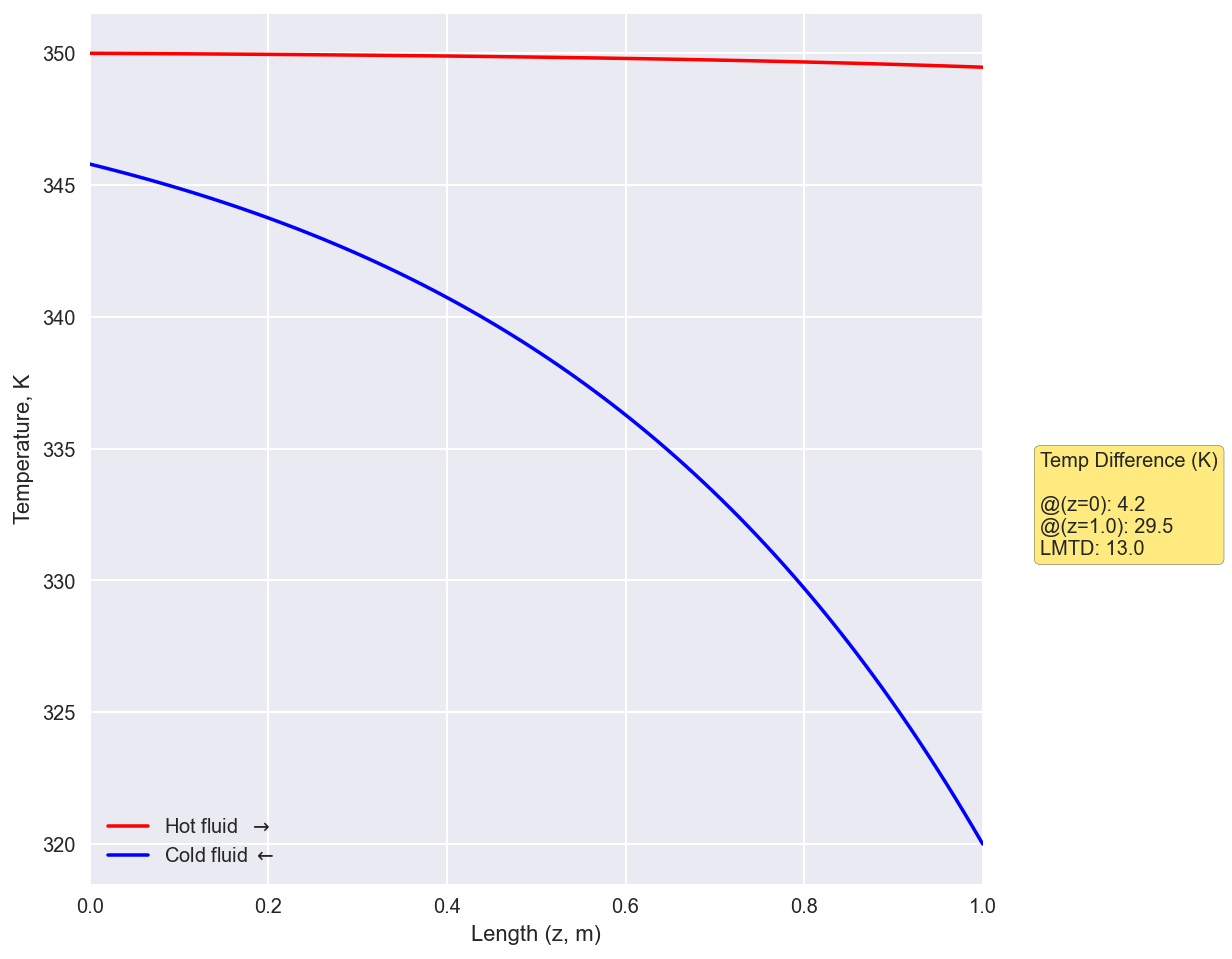

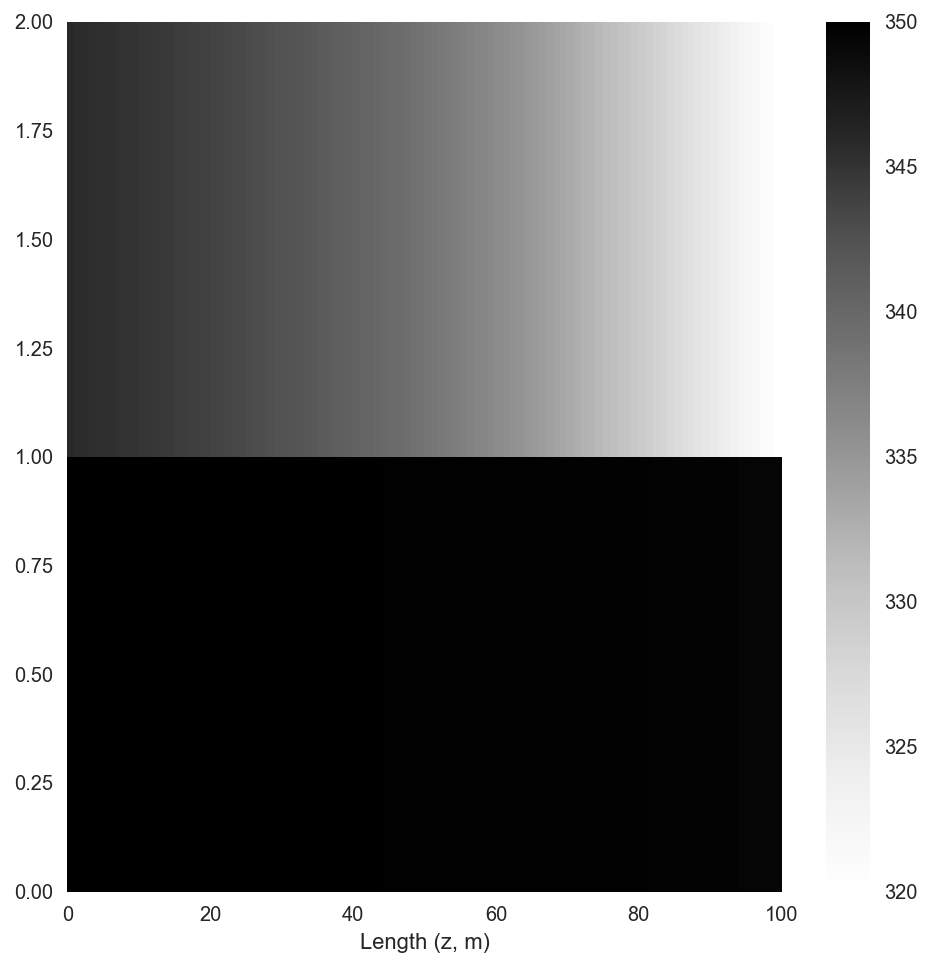

In [242]:
heatx = CrossHeatx()
heatx.mH = 1
heatx.mC = 0.01
heatx.T_Cin = 320
heatx.T_Hin = 350
heatx.solve()
heatx.plot()

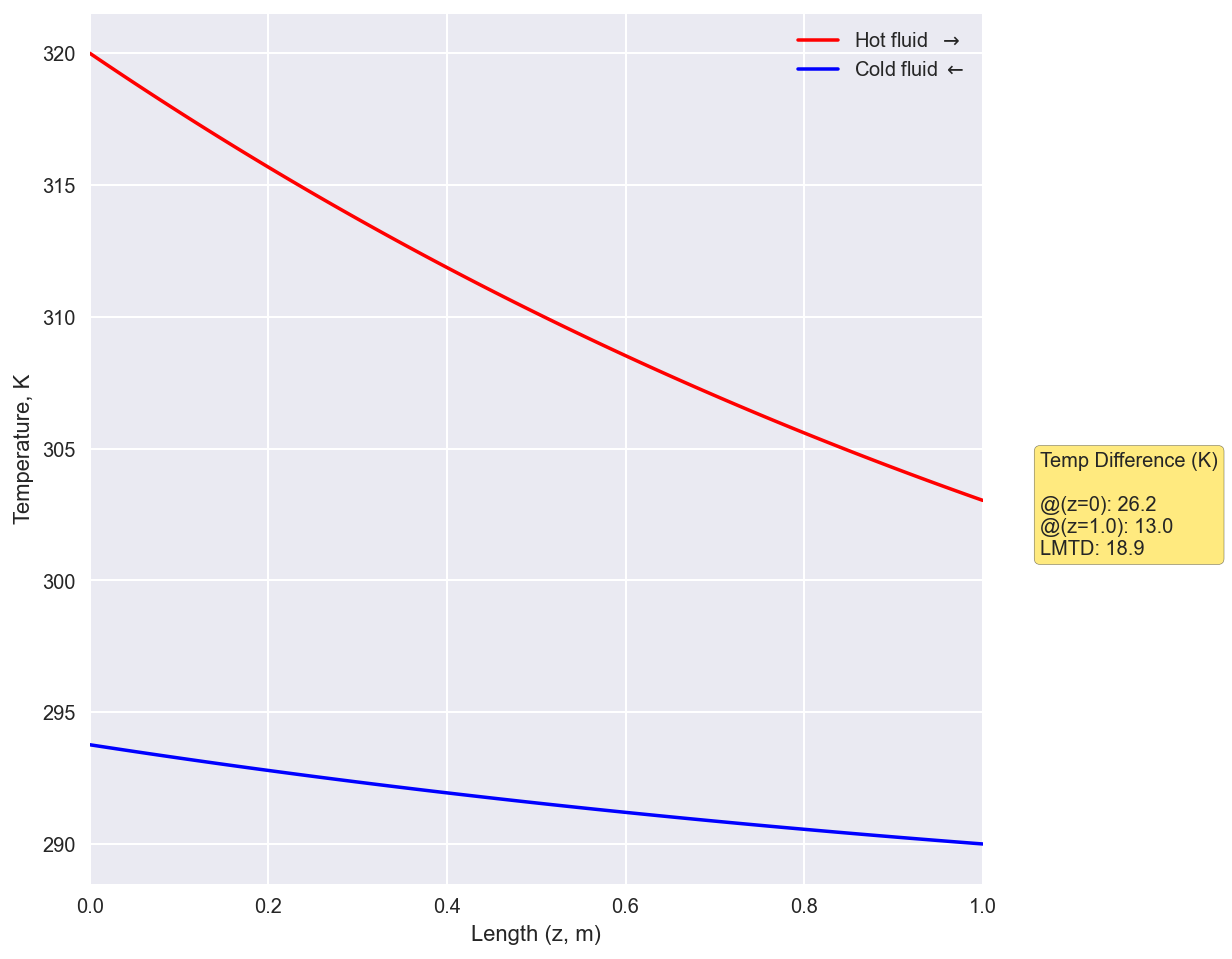

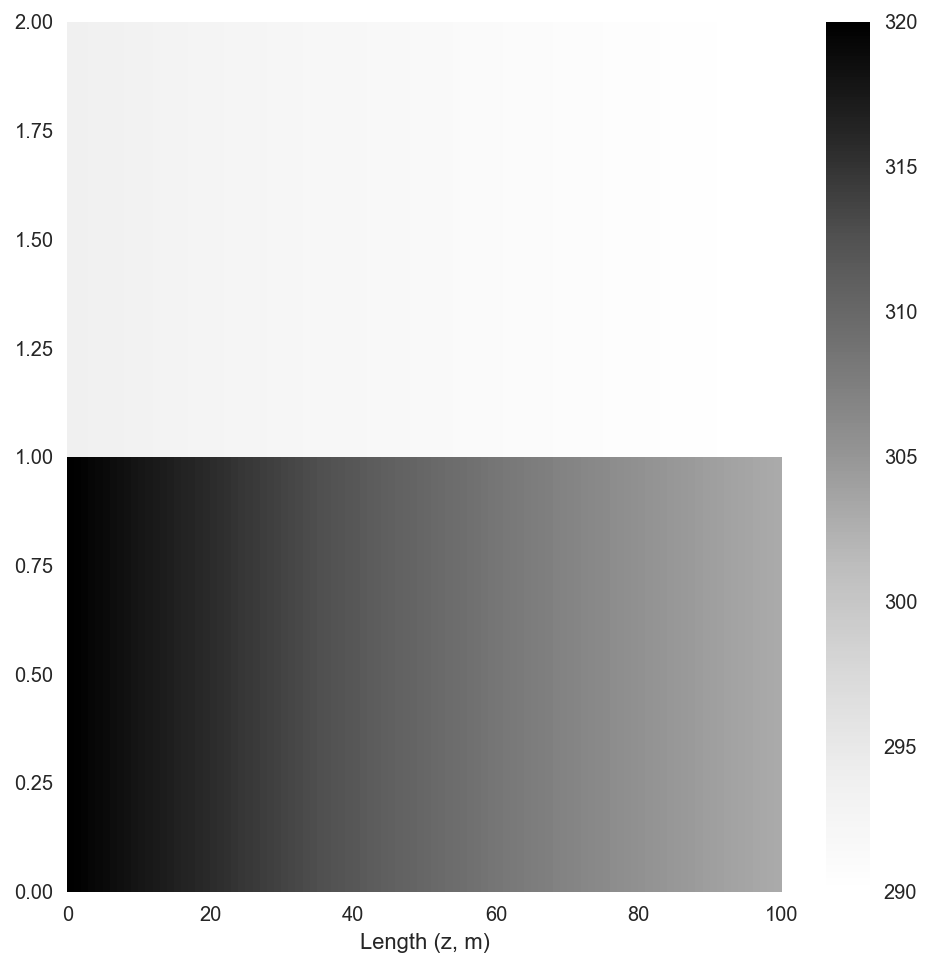

In [243]:
heatx = CrossHeatx()
heatx.mH = 0.05
heatx.mC = 0.1
heatx.T_Cin = 290
heatx.T_Hin = 320
heatx.solve()
heatx.plot()

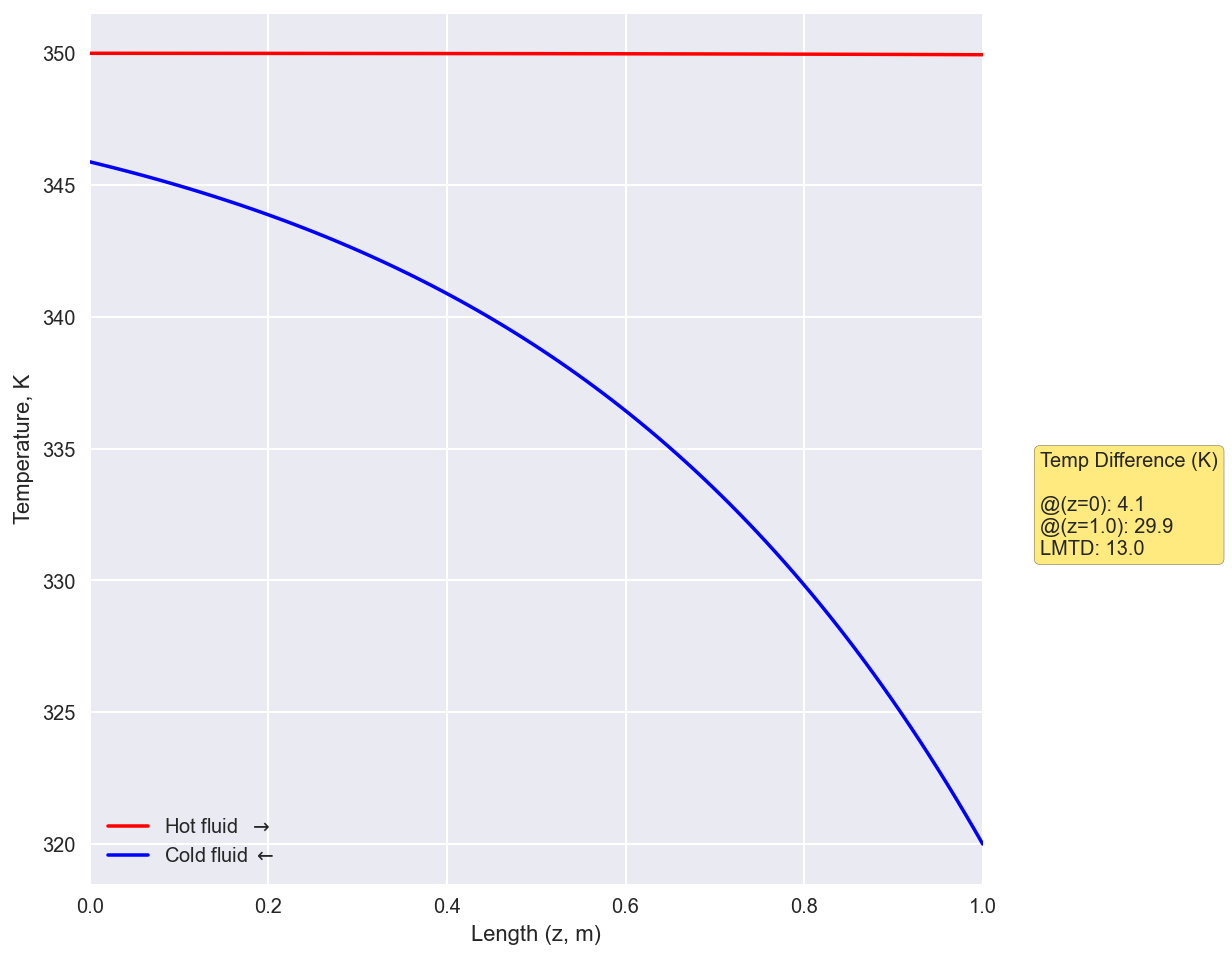

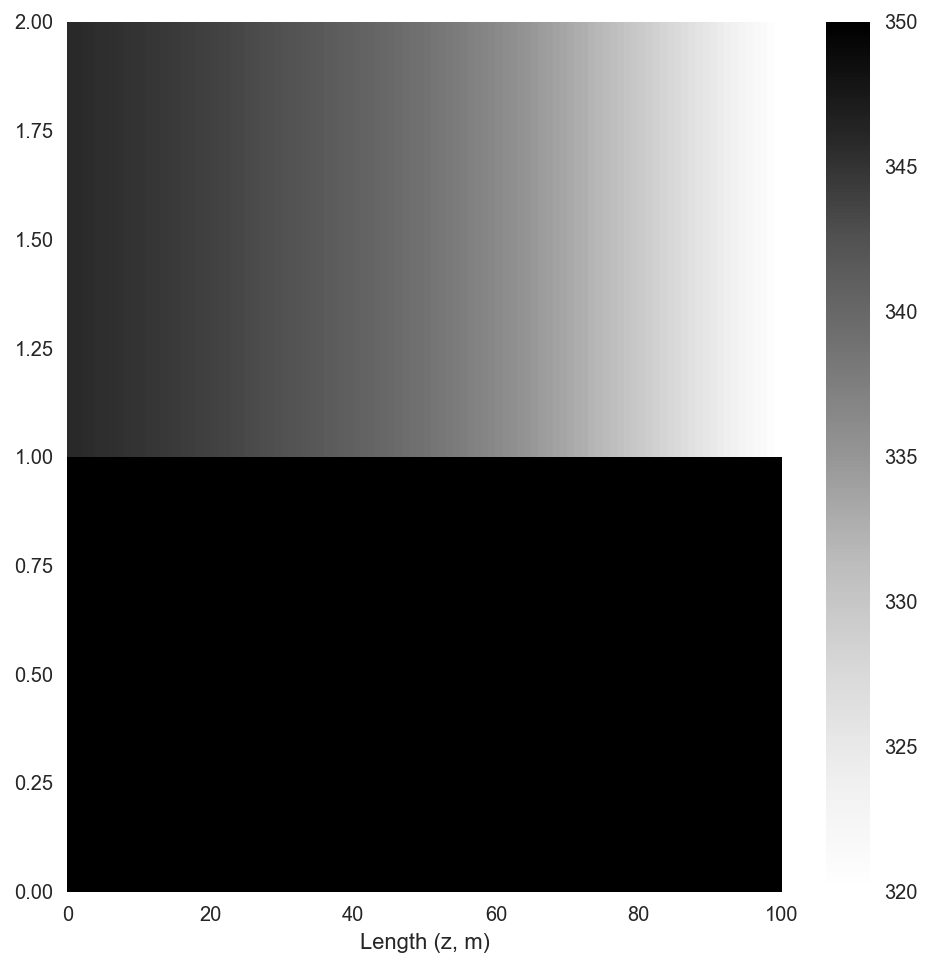

In [244]:
heatx = CrossHeatx()
heatx.mH = 10
heatx.mC = 0.01
heatx.T_Cin = 320
heatx.T_Hin = 350
heatx.solve()
heatx.plot()

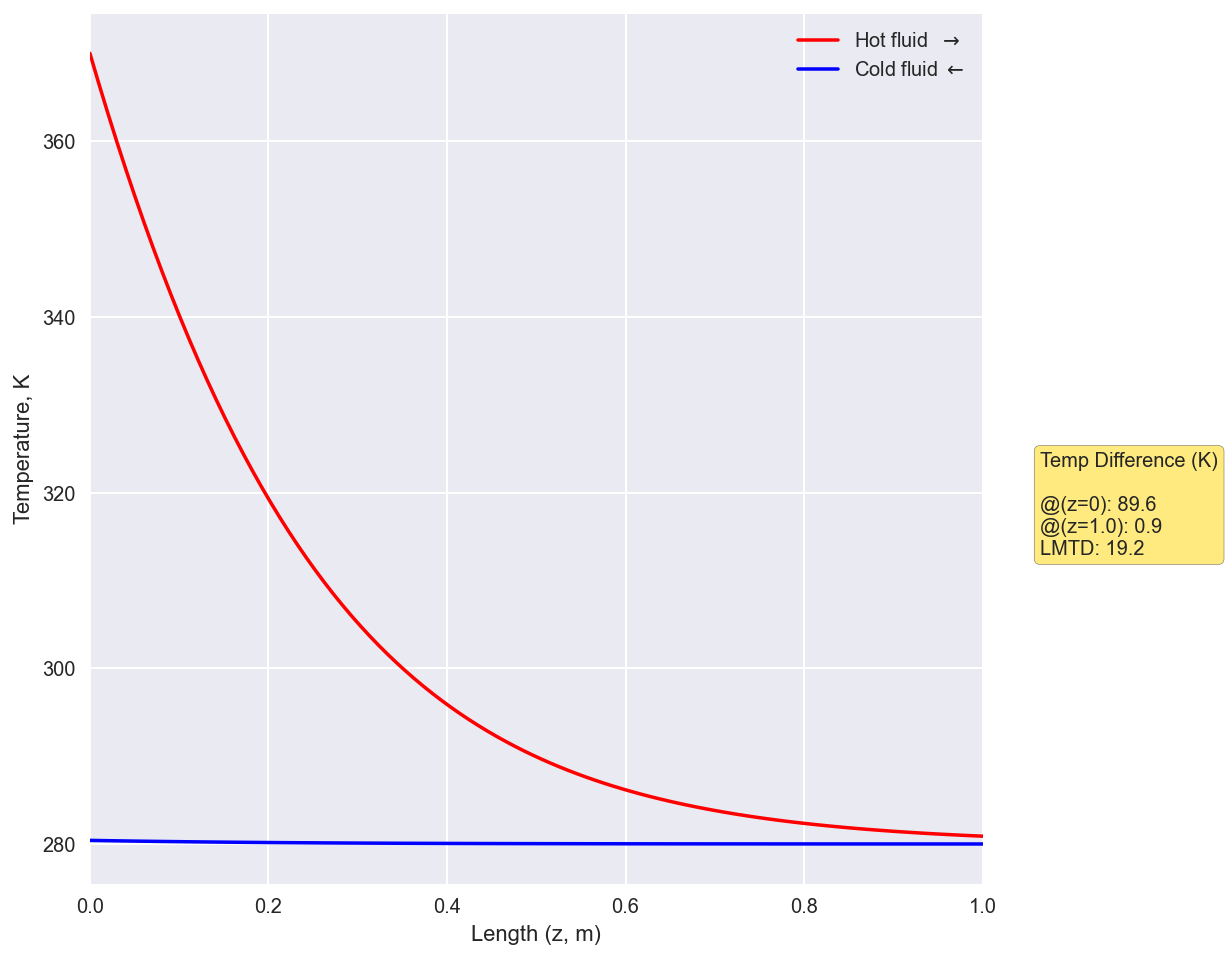

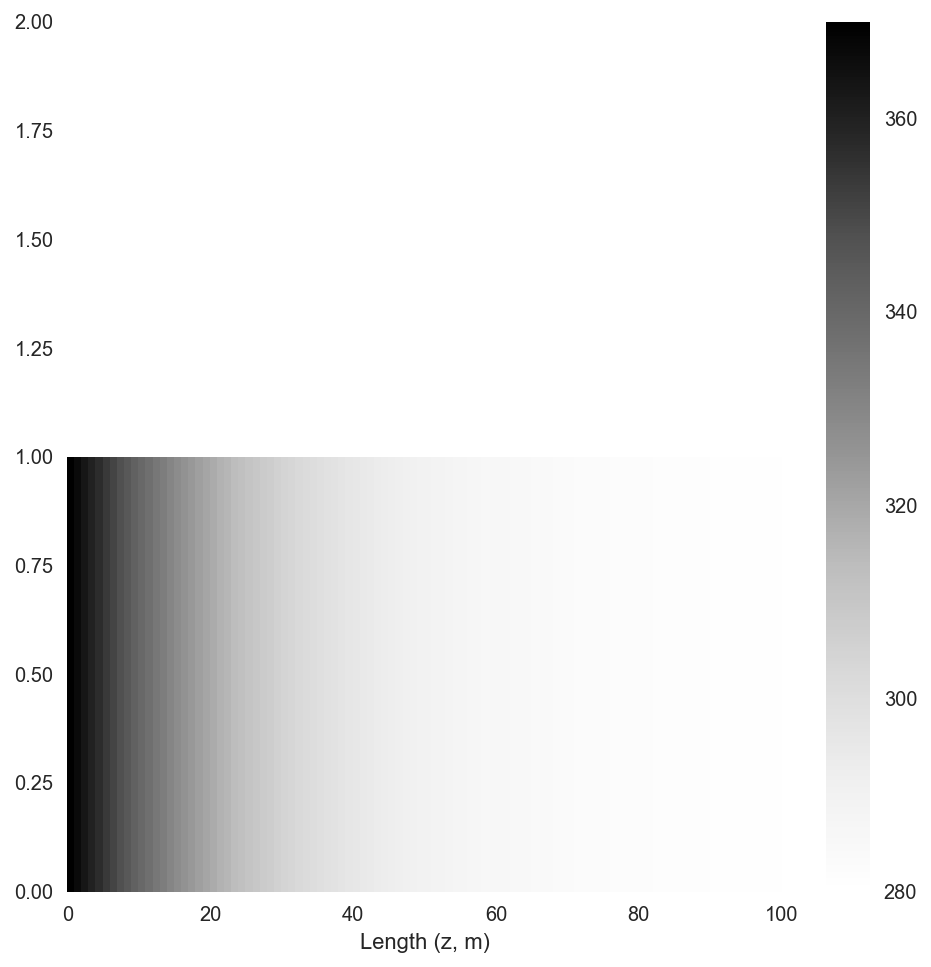

In [245]:
heatx = CrossHeatx()
heatx.mH = 0.01
heatx.mC = 1
heatx.T_Cin = 280
heatx.T_Hin = 370
heatx.solve()
heatx.plot()

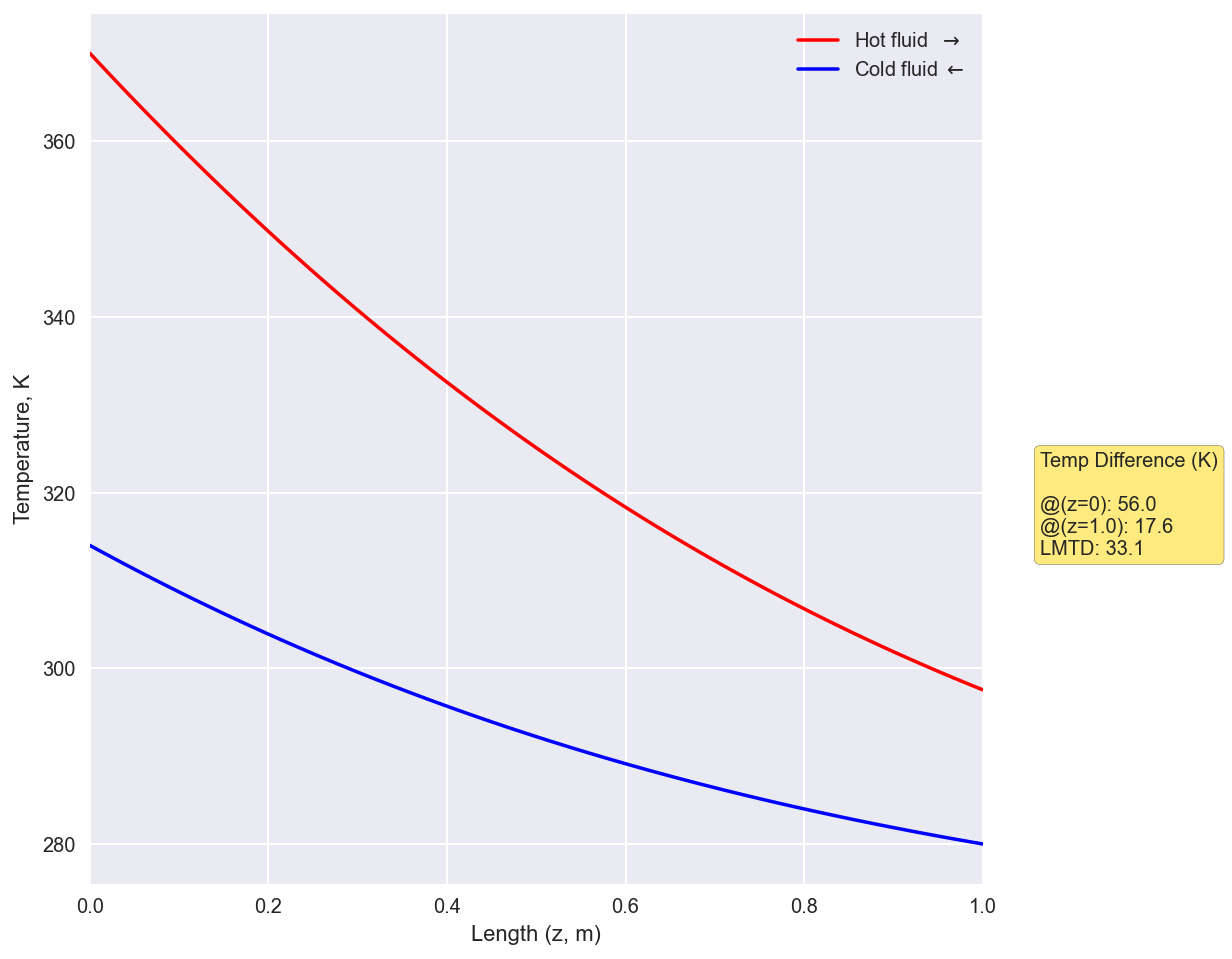

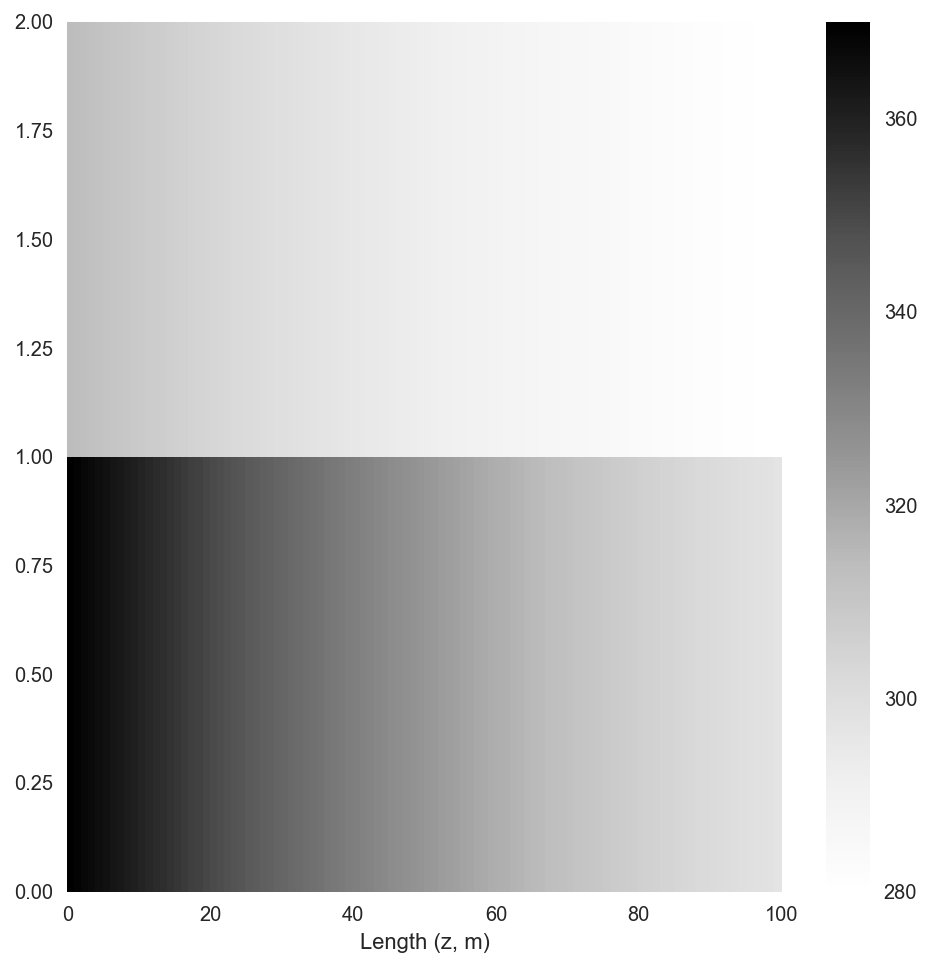

In [246]:
heatx = CrossHeatx()
heatx.mH = 0.1
heatx.mC = 0.1
heatx.U = 400
heatx.P = 1
heatx.T_Cin = 280
heatx.T_Hin = 370
heatx.solve()
heatx.plot()